In [1]:
import warnings
import time
import sys
import datetime
import joblib
import lightgbm as lgb
import os
import pickle
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import accuracy_score

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('../Kaggle-data/processed/train_processed_clv&churn&ltv&change_ratio.csv')
df_test = pd.read_csv('../aggle-data/processed/test_processed_clv&churn&ltv&change_ratio.csv')

In [127]:
df_train.shape

(201917, 340)

In [129]:
# RFE
# データ準備
X = df_train.drop(['target', 'first_active_month', 'card_id'], axis=1)
y = df_train['target']

# LightGBMモデルのインスタンス化
model = lgb.LGBMRegressor(num_leaves=111,
                          min_data_in_leaf=149,
                          objective='regression',
                          max_depth=9,
                          learning_rate=0.005,
                          boosting_type='gbdt',
                          feature_fraction=0.7522,
                          bagging_freq=1,
                          bagging_fraction=0.7083,
                          bagging_seed=11,
                          metric='rmse',
                          lambda_l1=0.2634,
                          random_state=133,
                          verbosity=-1)

# RFEの実行
# n_features_to_selectを総特徴量数の95%に設定
n_features_to_select = int(X.shape[1] * 0.95)
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X, y)

# 選択された特徴量
selected_features = X.columns[rfe.support_].tolist()

# 選択された特徴量で新しいデータフレームを作成
df_train_90 = df_train[selected_features + ['target']]
df_test_90 = df_test[selected_features]

# KFold で交差検証を行い、RMSEを計算
folds = KFold(n_splits=2, shuffle=True, random_state=42)
oof = np.zeros(len(X))
models_for_RFE = []
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"Fold {fold_ + 1}")
    X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[val_idx]

    # LightGBMのデータセットに変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    gbm = lgb.train(model.get_params(),
                    lgb_train,
                    num_boost_round=10000,
                    valid_sets=[lgb_train, lgb_valid],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])
   
    # モデルの保存
    models_for_RFE.append(gbm)

    # Out of Fold予測
    oof[val_idx] = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
    # Foldごとのスコアの表示
    fold_rmse = np.sqrt(mean_squared_error(y_valid, oof[val_idx]))
    print(f'Fold {fold_ + 1} RMSE: {fold_rmse}')

# CVのRMSEを計算
cv_rmse = np.sqrt(mean_squared_error(y, oof))
print(f'Cross-validation RMSE: {cv_rmse}')


Fold 1


C:\Users\toshiki.kawai.sx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 3.68338	valid_1's rmse: 3.77893
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.68338	valid_1's rmse: 3.77893
Fold 1 RMSE: 3.778925209099988
Fold 2


C:\Users\toshiki.kawai.sx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 3.74138	valid_1's rmse: 3.71924
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 3.74138	valid_1's rmse: 3.71924
Fold 2 RMSE: 3.719242852248477
Cross-validation RMSE: 3.7492029383771204


In [114]:
# 結果の表示
print(f'選択された特徴量数: {len(selected_features)}')
print("選択された特徴量:")
selected_features

選択された特徴量数: 286
選択された特徴量:


['feature_2',
 'elapsed_time',
 'quarter',
 'days_feature1',
 'days_feature2',
 'days_feature3',
 'days_feature1_ratio',
 'days_feature2_ratio',
 'days_feature3_ratio',
 'feature_sum',
 'feature_mean',
 'feature_max',
 'feature_var',
 'history_transactions_count',
 'history_category_1_sum',
 'history_category_1_mean',
 'history_category_2_1.0_mean',
 'history_category_2_4.0_mean',
 'history_category_3_1.0_mean',
 'history_category_3_2.0_mean',
 'history_category_3_3.0_mean',
 'history_merchant_id_nunique',
 'history_merchant_category_id_nunique',
 'history_state_id_nunique',
 'history_city_id_nunique',
 'history_subsector_id_nunique',
 'history_purchase_amount_sum',
 'history_purchase_amount_mean',
 'history_purchase_amount_max',
 'history_purchase_amount_min',
 'history_purchase_amount_std',
 'history_installments_sum',
 'history_installments_mean',
 'history_installments_max',
 'history_installments_std',
 'history_purchase_month_mean',
 'history_purchase_month_max',
 'history_purcha

In [100]:
df_test_90.shape

(123623, 303)

In [105]:
df_train_90.to_csv('../Kaggle-data/processed/train_processed_clv&churn&ltv&change_ratio_RFE90.csv', index=False)
df_test_90.to_csv('../Kaggle-data/processed/test_processed_clv&churn&ltv&change_ratio_RFE90.csv', index=False)

In [133]:
# df_train_95.to_csv('../Kaggle-data/processed/train_processed_clv&churn&ltv&change_ratio_RFE95.csv', index=False)
# df_test_95.to_csv('../Kaggle-data/processed/test_processed_clv&churn&ltv&change_ratio_RFE95.csv', index=False)

In [ ]:
# df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
# df_test['first_active_month'] = pd.to_datetime(df_test['first_active_month'])

In [130]:
# 特徴量の情報
features = [c for c in df_train.columns if c not in ['card_id']]
categorical_feats = ['feature_1','feature_2', 'feature_3',]

In [ ]:
# # 特徴量とターゲットの分割
# X = df_train.drop(['target', 'card_id', 'first_active_month'], axis=1)
# y = df_train['target']

# # 訓練データとテストデータの分割
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# # LightGBMのデータセットに変換
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# # ハイパーパラメータの設定
# params = {'num_leaves': 111,
#          'min_data_in_leaf': 149,
#          'objective':'regression',
#          'max_depth': 9,
#          'learning_rate': 0.005,
#          "boosting": "gbdt",
#          "feature_fraction": 0.7522,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.7083 ,
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.2634,
#          "random_state": 133,
#          "verbosity": -1}

In [ ]:
# # early_stopping_callback = lgb.early_stopping(stopping_rounds=10)

# # モデルの学習
# gbm = lgb.train(params, lgb_train)


# # モデルの評価
# y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
# mse_train = mean_squared_error(y_train, y_pred_train)
# rmse_train = np.sqrt(mse_train)
# print(f'Train RMSE: {rmse_train}')

# y_pred_test = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
# mse_test = mean_squared_error(y_valid, y_pred_test)
# rmse_test = np.sqrt(mse_test)
# print(f'Validation RMSE: {rmse_test}')

# # モデルの保存
# joblib.dump(gbm, 'lightGBM_model.pkl')
# print("モデルが保存されました。")

In [80]:
df_train.head(5)

,new_purchase_amount_sum,auth_month_diff_mean,ratio_merchant_category_nu,total_date_max,history_month_diff_mean,new_purchase_month_mean,new_month_lag_mean_x,purchase_amount_sum_mean,auth_purchase_date_max,total_predicted_purchases,total_clv,hist_date_max,new_purchase_date_max,hist_predicted_purchases,auth_purchase_date_ptp,new_predicted_purchases,auth_category_1_sum,hist_clv,new_date_max,auth_category_1_mean,purchase_change_ratio_min,new_purchase_date_ptp,history_installments_sum,new_day_max,auth_purchase_month_std,history_category_1_sum,history_transactions_count,total_month_lag_mean,days_feature2,auth_month_lag_std,new_duration_max,auth_month_lag_mean,days_feature1,authorized_flag_mean,new_recency_rfm,new_day_min,purchase_amount_std_std,month_lag_std,hist_ratio_No,auth_purchase_date_min,ratio_amount_total,new_monetary_value,history_purchase_amount_min,days_feature2_ratio,new_purchase_amount_std,days_feature1_ratio,new_category_1_mean,history_month_lag_std,new_LTV,history_purchase_month_std,purchase_amount_max_mean,history_month_lag_mean,total_amount_median,history_purchase_amount_std,month_lag_mean,hist_month_lag_mean,history_purchase_amount_sum,auth_purchase_month_mean,new_T_rfm,purchase_amount_min_std,total_weekday_mean,hist_predicted_monetary_value,total_price_mean,new_amount_month_ratio_max,hist_amount_median,auth_merchant_id_nunique,new_purchase_date_min,history_purchase_month_mean,purchase_amount_sum_std,purchase_amount_std_mean,purchase_amount_min_mean,hist_duration,purchase_amount_count_mean,new_predicted_monetary_value,new_date_min,hist_weekday_mean,auth_category_2_1.0_mean,purchase_amount_mean_std,new_duration_min,history_purchase_amount_mean,days_feature3,history_installments_std,purchase_change_ratio_var,new_purchase_month_std,new_purchase_amount_max,purchase_change_ratio_max,new_amount_max,total_weekend_mean,hist_installments_sum,total_merchant_category_mode,history_purchase_amount_max,total_price_sum,hist_recency_rfm,installments_std_std,total_predicted_monetary_value,purchase_amount_count_std,purchase_amount_mean_mean,history_category_1_mean,total_frequency_rfm,new_weekday_mean,total_duration_min,hist_weekend_mean,hist_amount_month_ratio_min,auth_category_3_2.0_mean,new_price_sum,purchase_change_ratio_mean,city_id_purchase_amount_std,total_duration,new_duration_mean,hist_duration_min,hist_date_min,hist_merchant_category_mode,purchase_amount_max_std,new_merchant_category_mode,new_city_mode,new_category_3_2.0_mean,total_monetary_value,new_clv,history_category_3_2.0_mean,hist_price_max,auth_purchase_amount_sum,city_id_purchase_amount_max,hist_price_min,installments_purchase_amount_min,hist_frequency_rfm,elapsed_time,total_recency_rfm,total_installments_sum,hist_city_mode,hist_price_mean,installments_sum_mean,history_category_2_1.0_mean,city_id_purchase_amount_min,ratio_amount_mean,category_1_purchase_amount_min,new_purchase_month_max,installments_sum_std,new_amount_total,auth_installments_sum,total_LTV,auth_category_3_3.0_mean,history_installments_mean,hist_monetary_value,new_month_lag_mean_y,auth_purchase_amount_mean,new_price_min,new_category_1_sum,new_month_diff_mean,total_city_mode,installments_std_mean,auth_purchase_amount_std,new_amount_month_ratio_mean,hist_merchant_category_nu,total_merchant_category_nu,days_feature3_ratio,auth_transactions_count,new_price_max,hist_LTV,new_purchase_month_min,new_amount_month_ratio_min,installments_mean_std,installments_min_std,new_duration,new_amount_median,auth_purchase_amount_min,total_installments_mean,category_1_purchase_amount_std,total_frequency,category_1_installments_std,auth_merchant_category_id_nunique,history_month_lag_min,hist_installments_mean,installments_max_mean,hist_amount_total,auth_subsector_id_nunique,installments_max_std,history_merchant_category_id_nunique,total_amount_month_ratio_min,new_month_lag_std,new_price_mean,installments_purchase_amount_max,city_id_purchase_amount_mean,installments_purchase_amount_std,history_merchant_id_nunique,total_month_

In [131]:
X = df_train_95.drop(['target'], axis=1)
y = df_train_95['target']

# KFoldでデータを5分割
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X))
models = []
fold_scores = []
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"Fold {fold_ + 1}")
    X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[val_idx]

    # LightGBMのデータセットに変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # ハイパーパラメータの設定
    params = {'num_leaves': 111,
              'min_data_in_leaf': 149,
              'objective': 'regression',
              'max_depth': 9,
              'learning_rate': 0.005,
              "boosting": "gbdt",
              "feature_fraction": 0.7522,
              "bagging_freq": 1,
              "bagging_fraction": 0.7083,
              "bagging_seed": 11,
              "metric": 'rmse',
              "lambda_l1": 0.2634,
              "random_state": 133,
              "verbosity": -1}

    # モデルの学習
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=10000,
                    valid_sets=[lgb_train, lgb_valid],
                    callbacks=[lgb.early_stopping(stopping_rounds=300),
                               lgb.log_evaluation(100)])

    # モデルの保存
    models.append(gbm)

    # Out of Fold予測
    oof[val_idx] = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

    # Foldごとのスコアの表示
    fold_rmse = np.sqrt(mean_squared_error(y_valid, oof[val_idx]))
    fold_scores.append(fold_rmse)
    print(f'Fold {fold_ + 1} RMSE: {fold_rmse}')

    # 特徴量重要度の取得
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X.columns
    fold_importance_df["importance"] = gbm.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# CVスコアの計算と表示
cv_rmse = np.mean(fold_scores)
print(f'Cross Validation RMSE: {cv_rmse}')

Fold 1
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 3.70886	valid_1's rmse: 3.77257
[200]	training's rmse: 3.63434	valid_1's rmse: 3.72715
[300]	training's rmse: 3.58677	valid_1's rmse: 3.70604
[400]	training's rmse: 3.55268	valid_1's rmse: 3.6952
[500]	training's rmse: 3.52679	valid_1's rmse: 3.68902
[600]	training's rmse: 3.50515	valid_1's rmse: 3.68564
[700]	training's rmse: 3.4872	valid_1's rmse: 3.68333
[800]	training's rmse: 3.47071	valid_1's rmse: 3.68191
[900]	training's rmse: 3.45617	valid_1's rmse: 3.68112
[1000]	training's rmse: 3.44307	valid_1's rmse: 3.68064
[1100]	training's rmse: 3.43007	valid_1's rmse: 3.68051
[1200]	training's rmse: 3.41846	valid_1's rmse: 3.68061
[1300]	training's rmse: 3.40654	valid_1's rmse: 3.68051
Early stopping, best iteration is:
[1082]	training's rmse: 3.43213	valid_1's rmse: 3.68035
Fold 1 RMSE: 3.6803462373496485
Fold 2
Training until validation scores don't improve for 300 rounds
[100]	training's rmse:

In [134]:
joblib.dump(models, 'lightGBM_models.pkl')
print("モデルが保存されました。")

モデルが保存されました。


In [84]:
# 特徴量重要度の集計と表示
feature_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
feature_importance.reset_index()

,feature,importance
0,new_purchase_amount_sum,2285.4
1,total_date_max,1911.0
2,auth_month_diff_mean,1776.4
3,ratio_merchant_category_nu,1598.8
4,history_month_diff_mean,1485.2
5,purchase_amount_sum_mean,1456.8
6,new_month_lag_mean_x,1426.0
7,new_purchase_month_mean,1424.2
8,auth_purchase_date_max,1321.6
9,total_clv,1253.0


In [122]:
df_test_85.shape

(123623, 286)

In [ ]:
# 上位75%の閾値を計算
threshold = 100.8
important_cols = feature_importance[feature_importance >= threshold].index.tolist()
# print("\n特徴量重要度:")
# # print(feature_importance)

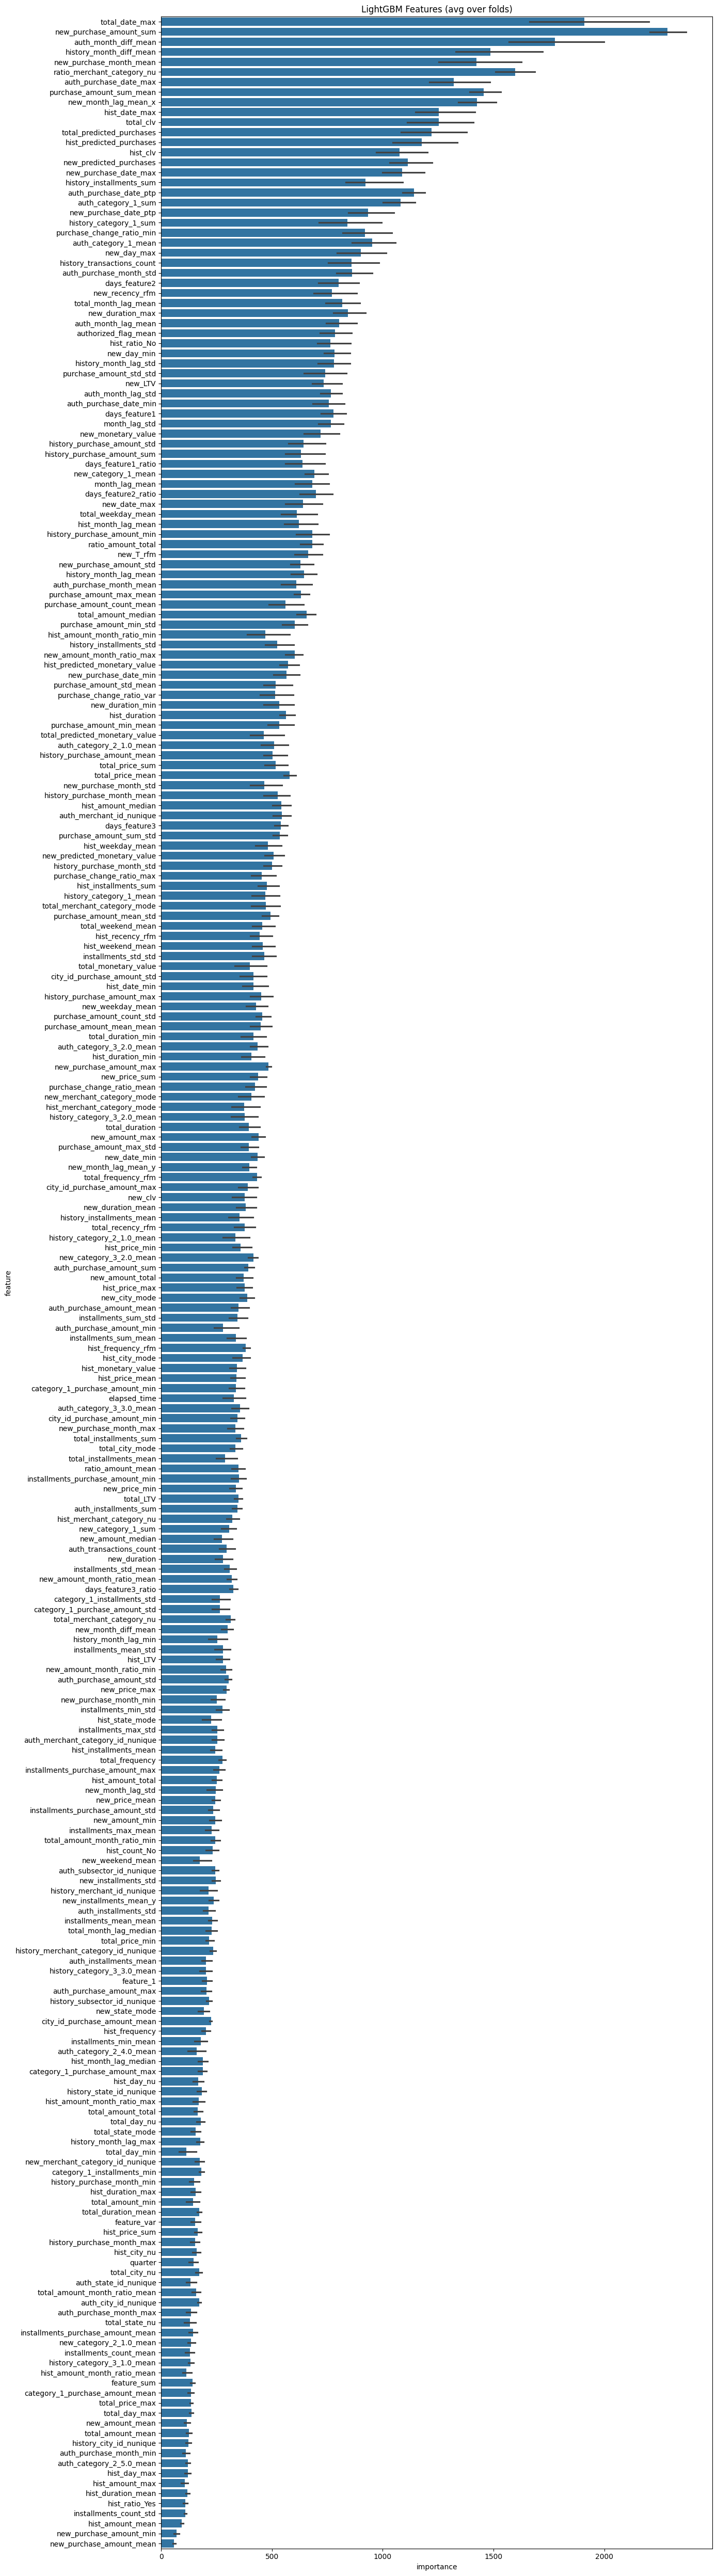

In [83]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [ ]:
len(important_cols)

In [ ]:
df_train_75 = pd.concat([df_train[important_cols], df_train[['target']]], axis=1)
df_test_75 = df_test[important_cols]

In [ ]:
df_train_75.shape

In [ ]:
df_test_75.shape

In [ ]:
df_train_75.to_csv('../Kaggle-data/processed/train_processed_clv&churn&ltv&change_ratio_top75.csv', index=False)
df_test_75.to_csv('../Kaggle-data/processed/test_processed_clv&churn&ltv&change_ratio_top75.csv', index=False)

In [ ]:
residuals = y - oof

# 残差のプロット
plt.figure(figsize=(10, 6))
plt.scatter(y, residuals, color='b', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Target')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [ ]:
# 予測値と訓練データの残差をプロット
plt.scatter(y_pred_train,             # グラフのx値(予測値)を定義
            y_pred_train - y_train,   # グラフのy値(予測値と訓練データの差)を定義
            c='red',                 # プロットの色を指定
            marker='o',               # マーカーの種類
            s=20,                     # マーカーのサイズ
            alpha=0.3,                # グラフの透過度
            label='train_data')         # ラベル名


# 予測値とテストデータの残差をプロット
plt.scatter(y_pred_test,
            y_pred_test - y_valid,
            c='green',
            marker='o',
            s=20,
            alpha=0.3,
            label='validation_data')

# グラフの詳細設定を行う
plt.xlabel('predict')
plt.ylabel('Residual error')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-20, xmax=20, lw=2, color='black')
plt.xlim([-20, 20])
plt.ylim([-50, 40])
plt.tight_layout()
plt.grid(True)
plt.show()